In [1]:
import keras
from keras.layers import Input, Activation, Dense, Conv2D, MaxPooling2D, Flatten, Lambda, Dropout
from keras.models import Model
import keras.backend as K
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
import tensorflow as tf
import math
from sklearn.manifold import TSNE
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
def triplet_mask_acc(y_true,y_pred,N=4096,beta=4096,alpha=2):
    #accuracy based on triplets. If anchor is closer to a positive+alpha, than to a    
    #negative, then we count that as a correct prediction  
    length=K.int_shape(y_pred)[1]
    anchor = y_pred[:,0:N]
    positive = y_pred[:,N:2*N]
    negative = y_pred[:,2*N:3*N]
    pos_dist = K.sum(K.square(anchor-positive),axis=1)

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)
    return K.cast((pos_dist + alpha < neg_dist),float)

def triplet_loss(y_true, y_pred, N = 4096, alpha=2):
    """ 
    Triplet loss function 
     
    Arguments: 
    y_true -- true labels
    y_pred -- list containing three objects: 
            anchor -- the encodings for the anchor data 
            positive -- the encodings for the positive data (similar to anchor) 
            negative -- the encodings for the negative data (different from anchor) 
    N  --  The number of dimension  
     
    Returns: 
    loss -- real number, value of the triplet loss 
    """  

    anchor = y_pred[:,0:N]
    positive = y_pred[:,N:2*N]
    negative = y_pred[:,2*N:3*N]

    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)

    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
 
    return loss

In [3]:
# Clear previous session if still in cache
K.clear_session()
def create_model():
    # Siamese Model
    net = keras.models.Sequential()

    net.add(keras.layers.Conv2D(filters=64, kernel_size=(10, 10),
                            input_shape=(105, 105, 1),
                            activation='relu',name='conv1'))
    net.add(keras.layers.MaxPool2D(pool_size=(2, 2)))

    net.add(keras.layers.Conv2D(filters=128, kernel_size=(7, 7),
                            activation='relu',name='conv2'))
    net.add(keras.layers.MaxPool2D(pool_size=(2, 2)))

    net.add(keras.layers.Conv2D(filters=128, kernel_size=(4, 4),
                            activation='relu'))
    net.add(keras.layers.MaxPool2D(pool_size=(2, 2),name='conv3'))

    net.add(keras.layers.Conv2D(filters=256, kernel_size=(4, 4),
                            activation='relu',name='conv4'))
    net.add(keras.layers.MaxPool2D(pool_size=(2, 2)))

    net.add(keras.layers.Flatten())
    net.add(keras.layers.Dense(units=4096, activation='sigmoid',name='dense'))
    return net

# Call the Sequential model on each input with shared weights.
pair_1st = keras.Input(shape=(105, 105, 1))
pair_2nd = keras.Input(shape=(105, 105, 1))
pair_3rd = keras.Input(shape=(105, 105, 1))

model = create_model()
anchor = model(pair_1st)
pos = model(pair_2nd)
neg = model(pair_3rd)
# Merge three outputs into a single vector (12288,1)  
outputs = keras.layers.concatenate([anchor, pos, neg])

# Return a keras Model architecture.
final_model = keras.Model(inputs=[pair_1st, pair_2nd,pair_3rd], outputs=outputs)

In [4]:
decay_slope = 1/10.0

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses=[]
        self.best_val_acc = 0
        
def step_decay(epoch):
    #Although Adam is an adaptive learning rate algorithm, research has proven that 
    #it is a good practice to decay the learning rate every n steps  
    if not epoch%2:
        return K.get_value(optimizer.lr)*0.99
    return K.get_value(optimizer.lr)
  
loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay)
#in case val_loss doesn’t shrink for 6 epochs – stop training  
early_stopper = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=6, verbose=1)

callbacks_list = [lrate,loss_history,early_stopper]

optimizer = Adam(lr=1e-4,amsgrad=True)

In [5]:
final_model.compile(optimizer=optimizer,
                   loss=triplet_loss,
                   metrics=[triplet_mask_acc],)

In [6]:
final_model.layers[3].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 96, 96, 64)        6464      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 42, 42, 128)       401536    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 21, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 18, 128)       262272    
_________________________________________________________________
conv3 (MaxPooling2D)         (None, 9, 9, 128)         0         
_________________________________________________________________
conv4 (Conv2D)               (None, 6, 6, 256)         524544    
__________

In [7]:
from matplotlib import pyplot as plt 
%matplotlib inline
import glob
import cv2
import numpy as np
from collections import Counter
from IPython.core.display import display, HTML
import random

In [8]:
dataset_train_path , dataset_evaluation_path = ("python/images_background/","python/images_evaluation/")

languages = [path.split("/")[-1] for path in glob.glob(dataset_train_path+"*")]
languages_evaluation = [path.split("/")[-1] for path in glob.glob(dataset_evaluation_path+"*")]

In [9]:
symbols = {language:[] for language in languages}
for path in glob.glob(dataset_train_path+"/*/*"):
    symbols[path.split("/")[2]].append(path.split("/")[3])
symbols_eval = {language:[] for language in languages_evaluation}
for path in glob.glob(dataset_evaluation_path+"/*/*"):
    symbols_eval[path.split("/")[2]].append(path.split("/")[3])

In [10]:
# Read and process data to arrays and dicts  
all_alphabets = {language:{symbol:[cv2.cvtColor(cv2.imread(image),cv2.COLOR_RGB2GRAY) for image in glob.glob(dataset_train_path+language+'/'+symbol+"/*")] for symbol in symbols[language]}\
                                                                  for language in languages }
all_images = []
for language in all_alphabets:
    for char in all_alphabets[language]:
        all_images.append(all_alphabets[language][char])
all_images = np.array(all_images)       
all_evaluation_alphabets = {language:{symbol:[cv2.cvtColor(cv2.imread(image),cv2.COLOR_RGB2GRAY) for image in glob.glob(dataset_evaluation_path+language+'/'+symbol+"/*")] for symbol in symbols_eval[language]}\
                                                                  for language in languages_evaluation[5:] }
all_test_alphabets = {language:{symbol:[cv2.cvtColor(cv2.imread(image),cv2.COLOR_RGB2GRAY) for image in glob.glob(dataset_evaluation_path+language+'/'+symbol+"/*")] for symbol in symbols_eval[language]}\
                                                                  for language in languages_evaluation[:5] }
all_evaluation_images = []
for language in all_evaluation_alphabets:
    for char in all_evaluation_alphabets[language]:
        all_evaluation_images.append(all_evaluation_alphabets[language][char])
all_evaluation_images = np.array(all_evaluation_images)
        
all_test_images = []
for language in all_test_alphabets:
    for char in all_test_alphabets[language]:
        all_test_images.append(all_test_alphabets[language][char])
all_test_images = np.array(all_test_images)

In [11]:
#create a batch of triplets (batch_size,3,105,105,1) to feed it into the model  
def augmented_generator_triplet(features,batch_size,validation):
    
    batch_features = np.zeros((batch_size, 3,105, 105,1))
    y = np.ones(batch_size)
    ceil = all_evaluation_images.shape[0] if validation else all_images.shape[0]
    while True:
        for i in range(batch_size):
            anchor = np.random.choice(range(ceil),2,replace=False)
            indices = np.random.randint(0,20,3)
            image1,image2,image3 = features[anchor[0],indices[0]].reshape(105,105,1),features[anchor[0],indices[1]].reshape(105,105,1),features[anchor[1],indices[2]].reshape(105,105,1)
            batch_features[i] = [image1,image2,image3]
            
        yield [batch_features[:,0],batch_features[:,1],batch_features[:,2]], y

In [12]:
#train out Siamese Neural Network using the above triplet generator
history = final_model.fit_generator(augmented_generator_triplet(all_images,128,False),
        validation_data= augmented_generator_triplet(all_evaluation_images,128,True),
        validation_steps = 100,
        steps_per_epoch=100,
        verbose=2,
        epochs=100,
        callbacks=callbacks_list)

Epoch 1/100
 - 20s - loss: 0.8655 - triplet_mask_acc: 0.5771 - val_loss: 0.9444 - val_triplet_mask_acc: 0.5309
Epoch 2/100
 - 16s - loss: 0.7494 - triplet_mask_acc: 0.6024 - val_loss: 0.9291 - val_triplet_mask_acc: 0.5662
Epoch 3/100
 - 16s - loss: 0.7457 - triplet_mask_acc: 0.6147 - val_loss: 0.9273 - val_triplet_mask_acc: 0.5552
Epoch 4/100
 - 16s - loss: 0.7114 - triplet_mask_acc: 0.6348 - val_loss: 0.8540 - val_triplet_mask_acc: 0.4984
Epoch 5/100
 - 16s - loss: 0.6346 - triplet_mask_acc: 0.6791 - val_loss: 0.7828 - val_triplet_mask_acc: 0.6709
Epoch 6/100
 - 16s - loss: 0.5262 - triplet_mask_acc: 0.7302 - val_loss: 0.6361 - val_triplet_mask_acc: 0.7250
Epoch 7/100
 - 16s - loss: 0.4059 - triplet_mask_acc: 0.7892 - val_loss: 0.5580 - val_triplet_mask_acc: 0.7817
Epoch 8/100
 - 16s - loss: 0.3007 - triplet_mask_acc: 0.8384 - val_loss: 0.4665 - val_triplet_mask_acc: 0.7922
Epoch 9/100
 - 16s - loss: 0.2676 - triplet_mask_acc: 0.8637 - val_loss: 0.4268 - val_triplet_mask_acc: 0.8177
E

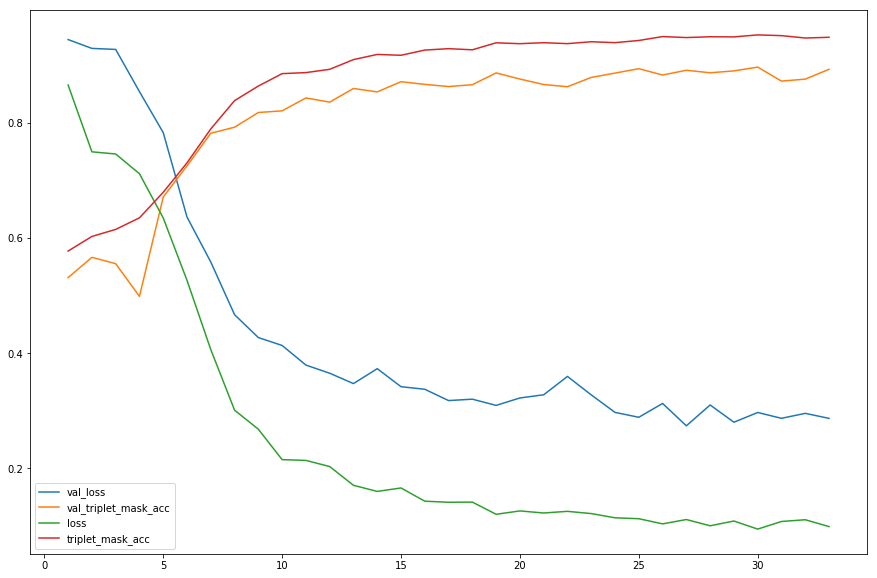

In [15]:
fig,ax=plt.subplots(figsize=(15,10)) # Visualize loss and accuracy
length = len(history.history['loss'])
for i in history.history:
    plt.plot(range(1,length+1),history.history[i])
plt.legend(['val_loss','val_triplet_mask_acc','loss','triplet_mask_acc'])

In [16]:
new_model = Model(inputs=final_model.layers[3].get_input_at(-1),outputs=final_model.layers[3].get_output_at(-1))

In [17]:
images = np.vstack((all_images,all_evaluation_images,all_test_images))

In [18]:
images.shape

(1623, 20, 105, 105)

In [19]:
def L2_distance(a,b):
    return np.linalg.norm(a-b)

In [20]:
N_way = 20 # against what amount of random samples to test
batch = np.random.randint(0,1623,10000)
score = 0
#for every random character create a set of N_way random characters and find   
#the closes character emebedding by predicting it with the model. In every set   
#there are guaranteed two images of the same class.  
for i in batch:
    ind_true = np.random.choice(20,2)
    indicies = np.random.randint(0,20,N_way-2)
    all_ind = np.hstack((ind_true,indicies))
    classes = np.random.randint(0,1623,N_way-2)
    imgs = [images[i,ind_true[0],:,:],images[i,ind_true[1],:,:]]
    for k,val in enumerate(indicies):
        imgs.append(images[classes[k],val,:,:])
    imgs = np.array(imgs).reshape(N_way,105,105,1)
    prediction = new_model.predict(imgs)
    distances = []
    classes = np.hstack((i,classes))
    for j in prediction[1:]:
        distances.append(L2_distance(prediction[0],j))
    predicted = distances.index(np.min(distances))
    if classes[predicted]==i: score += 1
print("Score on ",N_way," task: ",score/batch.shape[0]*100,"%")

Score on  20  task:  87.35000000000001 %


In [21]:
preds = np.array([new_model.predict(all_test_images[i].reshape(20,105,105,1)) for i in range(20)])

In [22]:
xs,ys,vec = preds.shape
preds = preds.reshape(xs*ys,vec)

In [25]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
preds_transformed = tsne.fit_transform(preds) # reduce the dimensionality of our 4096 vectors 
#and save the higher dimension representation for visualization  

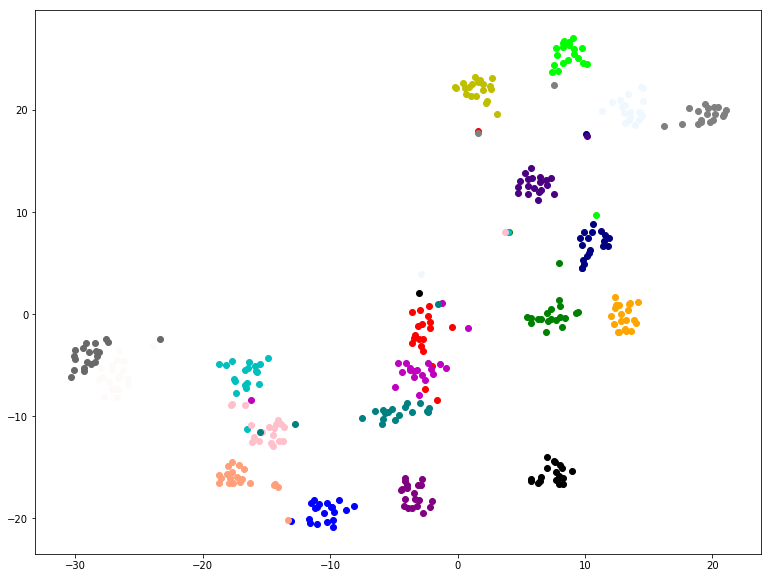

In [26]:
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple','pink','lime',
          'gray','snow','teal','aliceblue','navy','dimgray','lightsalmon','indigo']
plt.figure(figsize=(13, 10))
for i in range(20): #visualize  
    plt.scatter(preds_transformed.T[0][i*20:(i+1)*20],preds_transformed.T[1][i*20:(i+1)*20],c=colors[i])